<a href="https://colab.research.google.com/github/pobeidy1/py_custom_functions/blob/main/QSM_ISMRM_2021_Educational_interactive_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook accompanies the ISMRM 2021 educational talk on Quantitative Susceptibility Mapping. The talk recording and slides can be found here: https://ismrm-smrt21.us3.pathable.com/meetings/virtual/Jn6dtA8JfPZDc7Lem (and here: https://mri.sbollmann.net/index.php/2021/04/30/ismrm-2021-educational-talk-on-quantitative-susceptibility-mapping/)

If you run into any problems or have questions about this, please feel free to get in touch with me :) s.bollmann@uq.edu.au

# The QSM dipole inversion

Let's assume we have a susceptibility source in a static magnetic field: This source will disturb the magnetic field in its neighbourhood and will create a dipolar field perturbation. This field perturbation can be described by a forward model (for details refer to these excellent reviews: 
* Deistung, Andreas, Ferdinand Schweser, and Jürgen R. Reichenbach. ‘Overview of Quantitative Susceptibility Mapping: Overview of Quantitative Susceptibility Mapping’. NMR in Biomedicine 30, no. 4 (April 2017): e3569. https://doi.org/10.1002/nbm.3569.
* Schweser, Ferdinand, Andreas Deistung, and Jürgen R. Reichenbach. ‘Foundations of MRI Phase Imaging and Processing for Quantitative Susceptibility Mapping (QSM)’. Zeitschrift Für Medizinische Physik 26, no. 1 (March 2016): 6–34. https://doi.org/10.1016/j.zemedi.2015.10.002.
  ) 

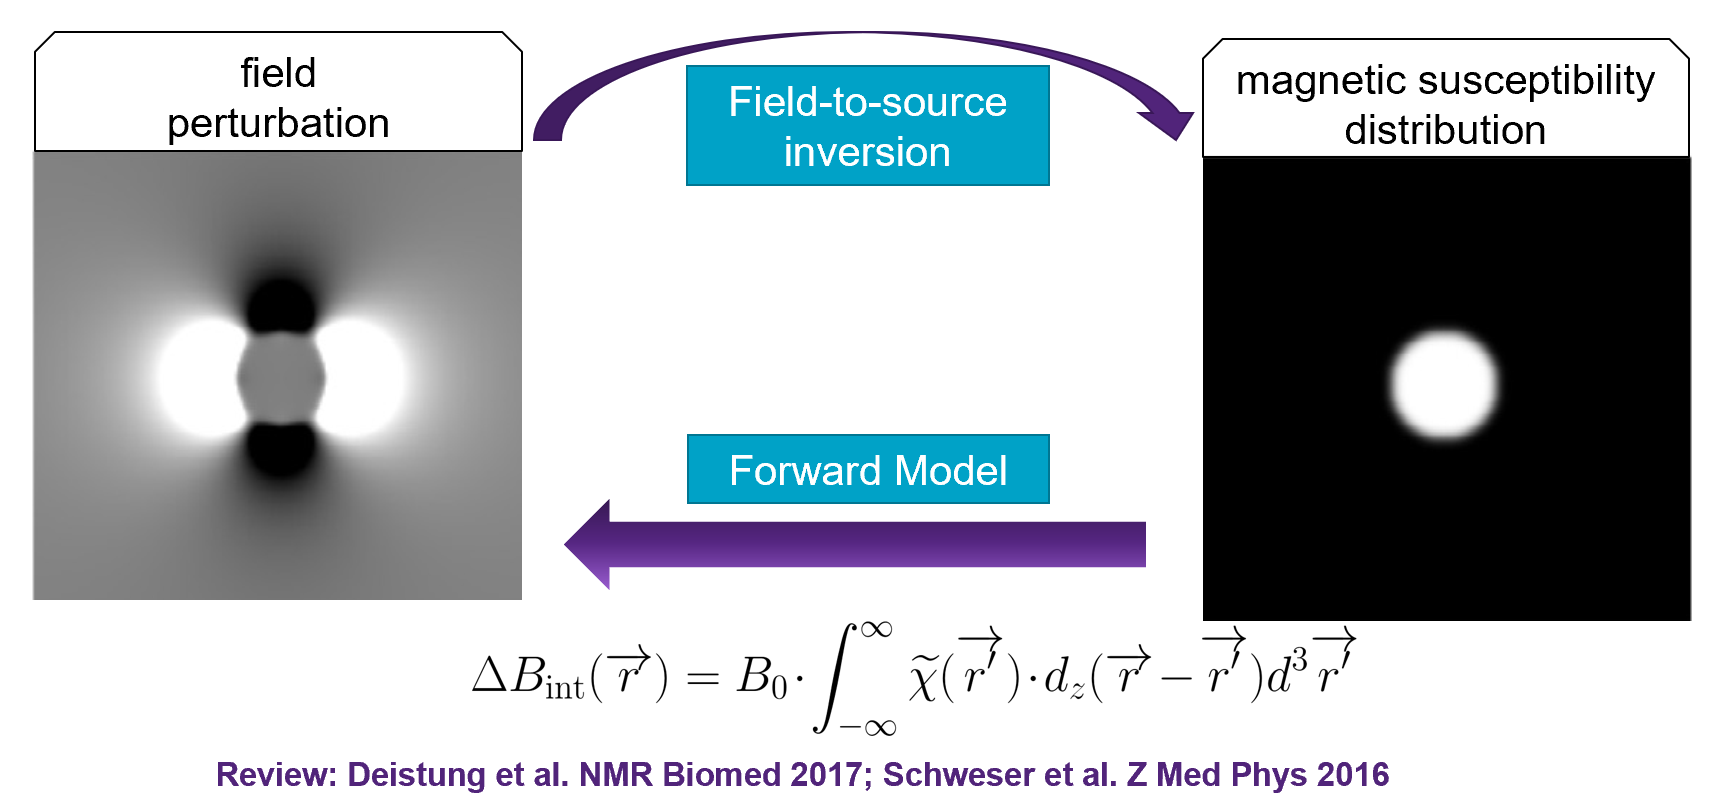

## Create susceptibility source
This code will generate geometric structures that we can use to illustrate the concepts in QSM. 

In [ ]:
import numpy as np
!pip install raster_geometry
import raster_geometry.raster as raster
import matplotlib.pyplot as plt


def view_slices_3d(image_3d, slice_nbr, vmin, vmax, title=''):
  fig = plt.figure(figsize=(15, 4))
  plt.suptitle(title, fontsize=10)

  plt.subplot(131)
  plt.imshow(np.take(image_3d, slice_nbr, 2), vmin=vmin, vmax=vmax, cmap='gray')
  plt.title('Axial');

  plt.subplot(132)
  image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 1),90)
  plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
  plt.title('Coronal');

  plt.subplot(133)
  image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 0),90)
  plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
  plt.title('Sagittal');
  cbar=plt.colorbar()

def simulate_susceptibility_sources(simulation_dim = 160, 
                                    rectangles_total = 0,
                                    spheres_total = 1,
                                    sus_std = 0.1,     # standard deviation of susceptibility values
                                    position_high = 1,
                                    position_low = 0,
                                    shape_size_min_factor = 0.1,
                                    shape_size_max_factor = 0.5):
  
  temp_sources = np.zeros((simulation_dim, simulation_dim, simulation_dim),dtype=np.float32)


  for shapes in range(rectangles_total):
    shrink_factor = 1/((shapes/rectangles_total+1))
    shape_size_min = np.floor(simulation_dim * shrink_factor * shape_size_min_factor)
    shape_size_max = np.floor(simulation_dim * shrink_factor * shape_size_max_factor)

    susceptibility_value = np.random.normal(loc=0.0, scale=sus_std)
    random_sizex = np.random.randint(low=shape_size_min, high=shape_size_max)
    random_sizey = np.random.randint(low=shape_size_min, high=shape_size_max)
    random_sizez = np.random.randint(low=shape_size_min, high=shape_size_max)
    x_pos = np.random.randint(simulation_dim)
    y_pos = np.random.randint(simulation_dim)
    z_pos = np.random.randint(simulation_dim)

    x_pos_max = x_pos + random_sizex
    if x_pos_max >= simulation_dim:
        x_pos_max = simulation_dim

    y_pos_max = y_pos + random_sizey
    if y_pos_max >= simulation_dim:
        y_pos_max = simulation_dim

    z_pos_max = z_pos + random_sizez
    if z_pos_max >= simulation_dim:
        z_pos_max = simulation_dim

    temp_sources[x_pos:x_pos_max, y_pos:y_pos_max, z_pos:z_pos_max] = susceptibility_value

  for shperes in range(spheres_total):
    susceptibility_value = np.random.normal(loc=0.0, scale=sus_std)
    radius = np.random.randint(low=1, high=simulation_dim/10)
    rel_positionX = np.random.uniform(low=position_low, high=position_high)
    rel_positionY = np.random.uniform(low=position_low, high=position_high)
    rel_positionZ = np.random.uniform(low=position_low, high=position_high)
    # print(radius)
    sphere = raster.sphere(simulation_dim, radius, position=[rel_positionX, rel_positionY, rel_positionZ])
    temp_sources[sphere] = susceptibility_value
    
  return temp_sources

     |████████████████████████████████| 182 kB 4.5 MB/s 
     |████████████████████████████████| 69 kB 3.6 MB/s 
     |████████████████████████████████| 58 kB 5.2 MB/s 


We will use this to generate a sqerical source in the middle of our object:

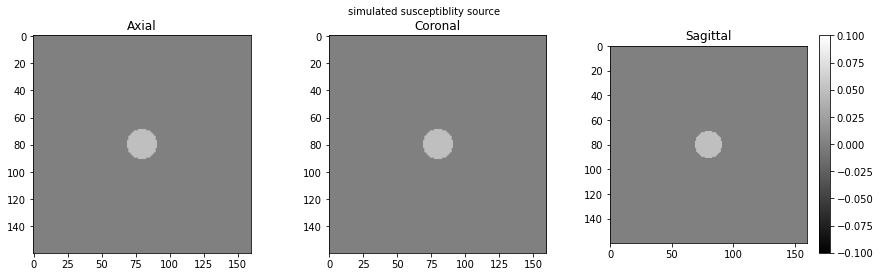

In [ ]:
from scipy import ndimage

np.random.seed(42) #make pseudorandom so everyone get's the same results!

sim_gt_full = simulate_susceptibility_sources(simulation_dim = 160, position_high = 0.5, position_low= 0.5)
view_slices_3d(sim_gt_full, slice_nbr=80, vmin=-0.1, vmax=0.1, title='simulated susceptiblity source')

## Create dipole kernel in k space
The dipole kernel describes how the magnetic field gets perturbed by the susceptibility source. Although it is a simplification it's a useful and managable description. Here we build the dipole kernel in K-space (in comparison to Image space: it is computationaly easier to handle in K-space because it would require convolutions in image space). 

In [ ]:
def generate_3d_dipole_kernel(data_shape, voxel_size, b_vec):
    fov = np.array(data_shape) * np.array(voxel_size)

    ry, rx, rz = np.meshgrid(np.arange(-data_shape[1] // 2, data_shape[1] // 2),
                             np.arange(-data_shape[0] // 2, data_shape[0] // 2),
                             np.arange(-data_shape[2] // 2, data_shape[2] // 2))

    rx, ry, rz = rx / fov[0], ry / fov[1], rz / fov[2]

    sq_dist = rx ** 2 + ry ** 2 + rz ** 2
    sq_dist[sq_dist == 0] = 1e-6
    d2 = ((b_vec[0] * rx + b_vec[1] * ry + b_vec[2] * rz) ** 2) / sq_dist
    kernel = (1 / 3 - d2)

    return kernel

In [ ]:
dipole_kernel = generate_3d_dipole_kernel(sim_gt_full.shape, voxel_size=1, b_vec=[0, 0, 1])

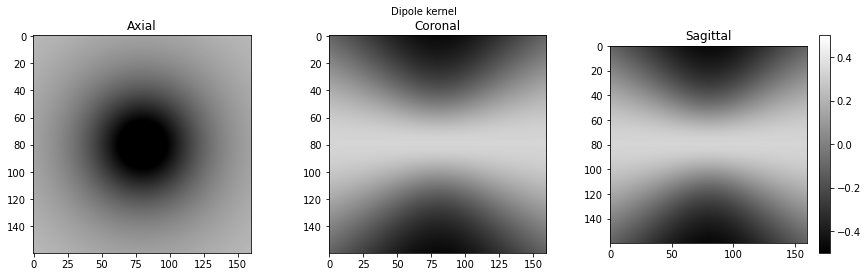

In [ ]:
view_slices_3d(dipole_kernel, slice_nbr=40, vmin=-0.5, vmax=0.5, title='Dipole kernel')

## Convolve Dipole Kernel with Source
To convolve the dipole kernel with our source, we can multiply the K-space Kernel with the Fourier transform of our source (which also brings this to K-space)

In [ ]:
def forward_convolution(chi_sample):
    scaling = np.sqrt(chi_sample.size)
    chi_fft = np.fft.fftn(chi_sample) / scaling
    
    chi_fft_t_kernel = chi_fft * np.fft.fftshift(generate_3d_dipole_kernel(chi_sample.shape, voxel_size=1, b_vec=[0, 0, 1]))
   
    tissue_phase = np.fft.ifftn(chi_fft_t_kernel)
    tissue_phase = np.real(tissue_phase * scaling)

    return tissue_phase
  
phs_tissue_simulated = forward_convolution(sim_gt_full)

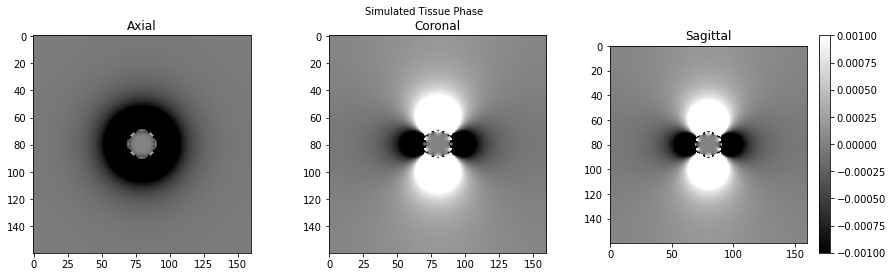

In [ ]:
view_slices_3d(phs_tissue_simulated, slice_nbr=80, vmin=-0.001, vmax=0.001, title='Simulated Tissue Phase')

## TKD QSM reconstruction
TKD solves the inverse problem by dividing the field perturbation by a truncated version of the dipole kernel (remember: the Dipole Kernel contains zeros, which would cause problems when dividing, so the truncation replaces the zeros by a fixed threshold parameter)

In [ ]:
threshold_tkd = 0.19      # TKD threshold parameter

kernel_inv = np.zeros(sim_gt_full.shape);
kernel_larger_threshold = np.abs(dipole_kernel) > threshold_tkd
kernel_inv[kernel_larger_threshold] = 1 / dipole_kernel[kernel_larger_threshold];

chi_tkd = np.real( np.fft.ifftn( np.fft.fftn(phs_tissue_simulated) * np.fft.fftshift(kernel_inv) ) ); 

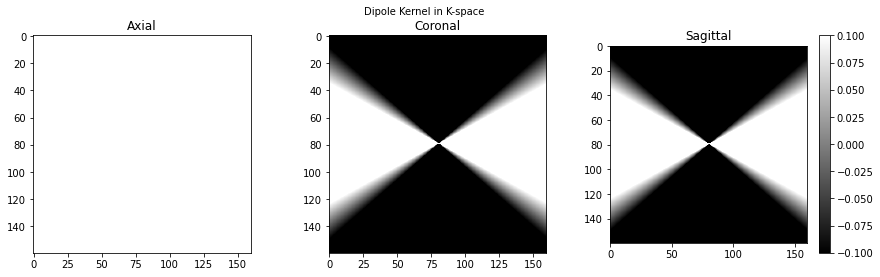

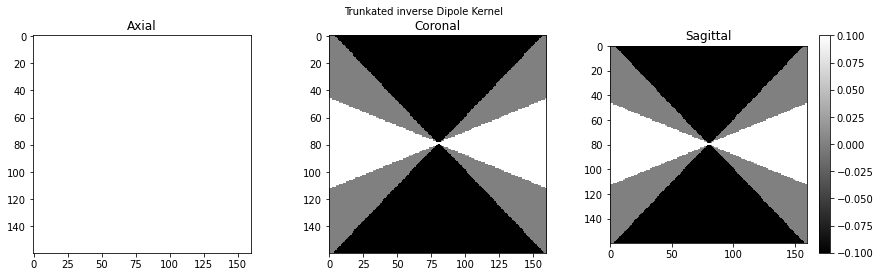

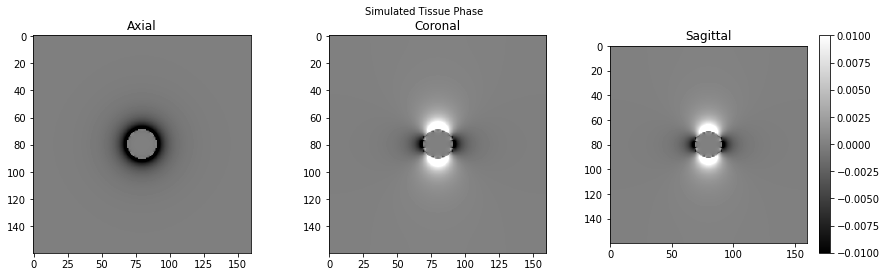

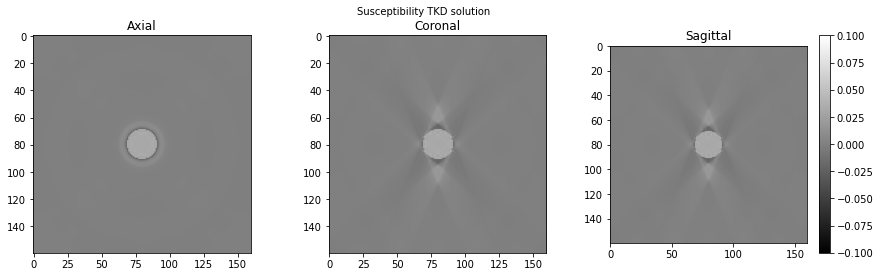

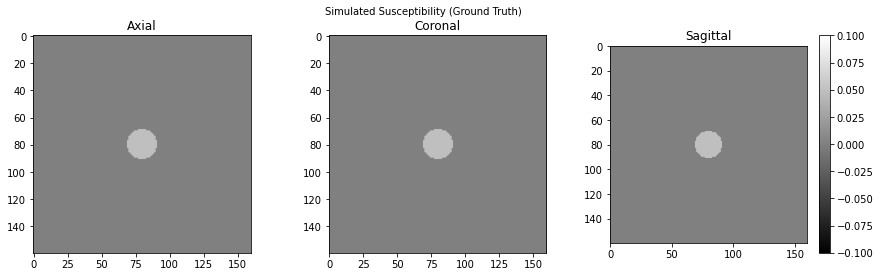

In [ ]:
view_slices_3d(dipole_kernel, slice_nbr=80, vmin=-0.1, vmax=0.1, title='Dipole Kernel in K-space')
view_slices_3d(kernel_inv, slice_nbr=80, vmin=-0.1, vmax=0.1, title='Trunkated inverse Dipole Kernel')
view_slices_3d(phs_tissue_simulated, slice_nbr=80, vmin=-0.01, vmax=0.01, title='Simulated Tissue Phase')
view_slices_3d(chi_tkd, slice_nbr=80, vmin=-0.1, vmax=0.1, title='Susceptibility TKD solution')
view_slices_3d(sim_gt_full, slice_nbr=80, vmin=-0.1, vmax=0.1, title='Simulated Susceptibility (Ground Truth)')

## Let's try this on real data
For this we will use the 2016 QSM reconstruction challenge dataset (Langkammer, Christian, Ferdinand Schweser, Karin Shmueli, Christian Kames, Xu Li, Li Guo, Carlos Milovic, et al. ‘Quantitative Susceptibility Mapping: Report from the 2016 Reconstruction Challenge: QSM Reconstruction Challenge 2016’. Magnetic Resonance in Medicine 79, no. 3 (March 2018): 1661–73. https://doi.org/10.1002/mrm.26830.
)

In [ ]:
!curl -J -O "https://cloudstor.aarnet.edu.au/plus/s/ZX99z7PbNihJEdR/download"
!unzip 20170327_qsm2016_recon_challenge.zip >> /dev/null
!rm 20170327_qsm2016_recon_challenge.zip
!ls -la

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  233M  100  233M    0     0  9949k      0  0:00:24  0:00:24 --:--:-- 10.4M
curl: Saved to filename '20170327_qsm2016_recon_challenge.zip'
total 36
drwxr-xr-x 1 root root 4096 Mar  4 00:08 .
drwxr-xr-x 1 root root 4096 Mar  3 23:55 ..
drwxr-xr-x 4 root root 4096 Mar  4 00:01 00_dicom
drwxr-xr-x 4 root root 4096 Mar  4 00:02 01_bids
drwxr-xr-x 5 root root 4096 Mar 27  2017 20170327_qsm2016_recon_challenge
drwxr-xr-x 1 root root 4096 Feb 18 14:33 .config
drwxr-xr-x 4 root root 4096 Mar  3 23:59 dicoms
drwxr-xr-x 4 root root 4096 Mar  3 23:58 osfstorage
drwxr-xr-x 1 root root 4096 Feb 18 14:33 sample_data


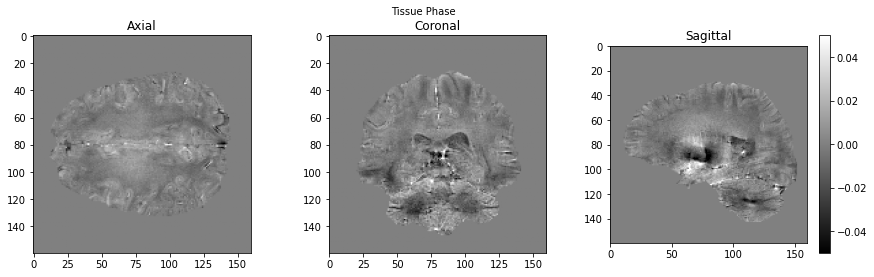

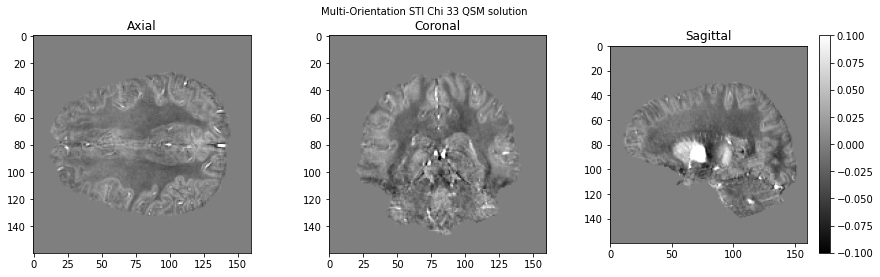

In [ ]:
import nibabel as nib
import numpy as np
from matplotlib import transforms
from scipy import ndimage
import pickle

# load data
tissue_phase = nib.load('20170327_qsm2016_recon_challenge/data/phs_tissue.nii.gz').get_fdata()
chi = nib.load('20170327_qsm2016_recon_challenge/data/chi_33.nii.gz').get_fdata()

view_slices_3d(tissue_phase, slice_nbr=100, vmin=-0.05, vmax=0.05, title='Tissue Phase')
view_slices_3d(chi, slice_nbr=100, vmin=-0.1, vmax=0.1, title='Multi-Orientation STI Chi 33 QSM solution')

In [ ]:
threshold_tkd = 0.19      # TKD threshold parameter

kernel_inv = np.zeros(sim_gt_full.shape);
kernel_larger_threshold = np.abs(dipole_kernel) > threshold_tkd
kernel_inv[kernel_larger_threshold] = 1 / dipole_kernel[kernel_larger_threshold];

chi_tkd = np.real( np.fft.ifftn( np.fft.fftn(tissue_phase) * np.fft.fftshift(kernel_inv) ) ); 

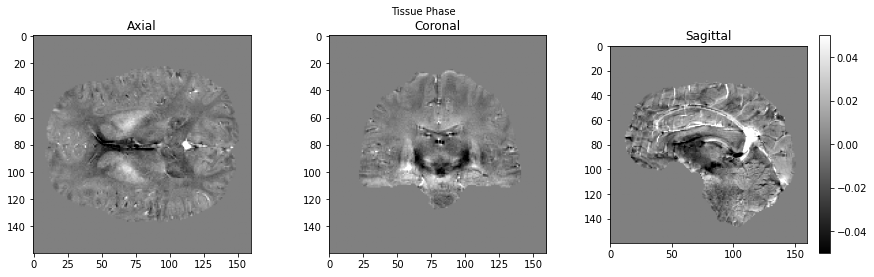

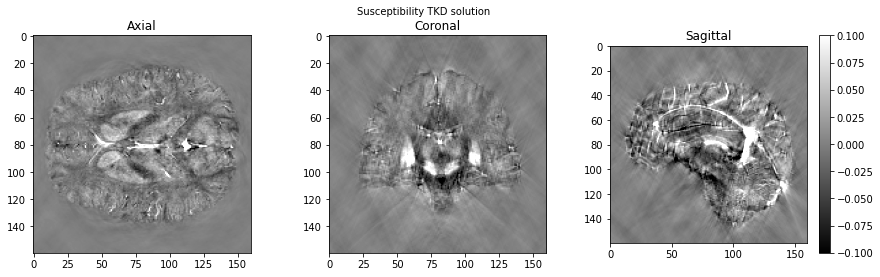

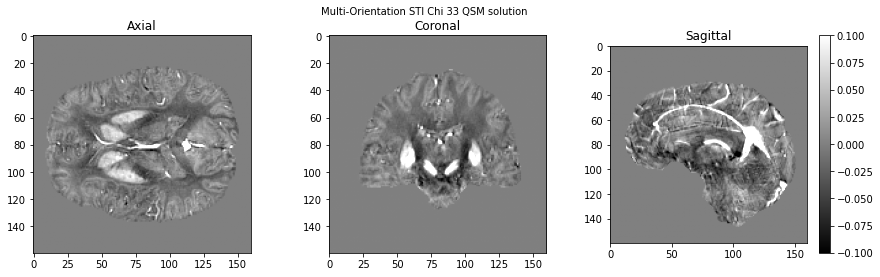

In [ ]:
view_slices_3d(tissue_phase, slice_nbr=80, vmin=-0.05, vmax=0.05, title='Tissue Phase')
view_slices_3d(chi_tkd, slice_nbr=80, vmin=-0.1, vmax=0.1, title='Susceptibility TKD solution')
view_slices_3d(chi, slice_nbr=80, vmin=-0.1, vmax=0.1, title='Multi-Orientation STI Chi 33 QSM solution')

# Let's invert this data using the TGV-QSM algorithm

The TGV QSM algorithm is described in this publication: Langkammer, Christian, Kristian Bredies, Benedikt A. Poser, Markus Barth, Gernot Reishofer, Audrey Peiwen Fan, Berkin Bilgic, Franz Fazekas, Caterina Mainero, and Stefan Ropele. ‘Fast Quantitative Susceptibility Mapping Using 3D EPI and Total Generalized Variation’. NeuroImage 111 (1 May 2015): 622–30. https://doi.org/10.1016/j.neuroimage.2015.02.041.

The google colab notebook runs Python commands by default, but by preceding a ! it runs the command on the underlying Linux terminal, so this means you could also try this on your own Linux machine if you like. The next code section sets up TGV-QSM and will take a few minutes to run (the >> /dev/null addition suppresses outputs to keep the notebook easier to read):

In [ ]:
# setup anaconda with Python 2 so we can run TGV-QSM:
!wget -c https://repo.anaconda.com/miniconda/Miniconda2-4.6.14-Linux-x86_64.sh
!chmod +x Miniconda2-4.6.14-Linux-x86_64.sh
!bash ./Miniconda2-4.6.14-Linux-x86_64.sh -b -f -p /usr/local >> /dev/null
!conda install -q -y --prefix /usr/local -c conda-forge cython==0.29.14 pyparsing numpy scipy==0.17.1 nibabel==2.1.0 pydicom==2.0.0 >> /dev/null
!wget http://www.neuroimaging.at/media/qsm/TGVQSM-plus.zip
!unzip TGVQSM-plus.zip >> /dev/null
!rm TGVQSM-master-011045626121baa8bfdd6633929974c732ae35e3/setup.py
!cd TGVQSM-master-011045626121baa8bfdd6633929974c732ae35e3/ && wget https://raw.githubusercontent.com/NeuroDesk/caid/master/recipes/tgvqsm/setup.py
!cd TGVQSM-master-011045626121baa8bfdd6633929974c732ae35e3/ && python setup.py install >> /dev/null
import sys 
sys.path.append('/usr/local/lib/python3.6/site-packages/')

--2021-05-11 05:00:10--  https://repo.anaconda.com/miniconda/Miniconda2-4.6.14-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45117115 (43M) [application/x-sh]
Saving to: ‘Miniconda2-4.6.14-Linux-x86_64.sh’

Miniconda2-4.6.14-L 100%[===================>]  43.03M   120MB/s    in 0.4s    

2021-05-11 05:00:11 (120 MB/s) - ‘Miniconda2-4.6.14-Linux-x86_64.sh’ saved [45117115/45117115]

Python 2.7.16 :: Anaconda, Inc.
--2021-05-11 05:04:37--  http://www.neuroimaging.at/media/qsm/TGVQSM-plus.zip
Resolving www.neuroimaging.at (www.neuroimaging.at)... 81.19.145.55
Connecting to www.neuroimaging.at (www.neuroimaging.at)|81.19.145.55|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69878007 (67M) [application/zip]
Saving to: ‘TGVQSM-plus.zip’

TGVQSM-plus.zip    

This is the content of the 2016 recon challenge data:

In [ ]:
!ls 20170327_qsm2016_recon_challenge/data/

chi_33.mat		magn.mat	 mprage_raw.nii.gz  phs_unwrap.nii.gz
chi_33.nii.gz		magn.nii.gz	 msk.mat	    phs_wrap.mat
chi_cosmos.mat		magn_raw.mat	 msk.nii.gz	    phs_wrap.nii.gz
chi_cosmos.nii.gz	magn_raw.nii.gz  phs_tissue.mat     spatial_res.mat
evaluation_mask.mat	mp_rage.mat	 phs_tissue.nii.gz  spatial_res.txt
evaluation_mask.nii.gz	mp_rage.nii.gz	 phs_unwrap.mat


The next line will run the TGV QSM algorithm on the data. It will take about 17 minutes to compute. 

In [ ]:
!cd 20170327_qsm2016_recon_challenge/data/ && tgv_qsm  -p phs_wrap.nii.gz -m msk.nii.gz -f 2.89 -t 0.02 -o tgv_qsm_recon_

 >>>>  TGV-QSM  <<<<< 
-----------------------------------------
loading files...
  phase: phs_wrap.nii.gz
  mask:  msk.nii.gz
  output: phs_wraptgv_qsm_recon__{number:03d}.nii.gz
Resampling phase data...
/usr/local/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:435: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter will change in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "
Resampling magnitude/mask data...
Data looks good!
Processing initial laplacian of phs_wrap.nii.gz ...
Processing QSM phs_wrap.nii.gz ...
Factor 1.0 (1 of 1) - alpha = (0.0015, 0.0005)
  Iterations: 1000 (1 of 1)
Progress: [*************************] 100.0% Done!
  Saved phs_wraptgv_qsm_recon__000.nii.gz
Finished!


In [ ]:
!ls 20170327_qsm2016_recon_challenge/data/

chi_33.mat		magn_raw.mat	   phs_tissue.nii.gz
chi_33.nii.gz		magn_raw.nii.gz    phs_unwrap.mat
chi_cosmos.mat		mp_rage.mat	   phs_unwrap.nii.gz
chi_cosmos.nii.gz	mp_rage.nii.gz	   phs_wrap.mat
evaluation_mask.mat	mprage_raw.nii.gz  phs_wrap.nii.gz
evaluation_mask.nii.gz	msk.mat		   phs_wraptgv_qsm_recon__000.nii.gz
magn.mat		msk.nii.gz	   spatial_res.mat
magn.nii.gz		phs_tissue.mat	   spatial_res.txt


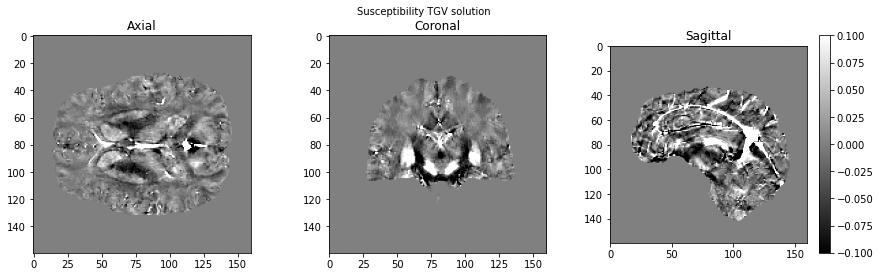

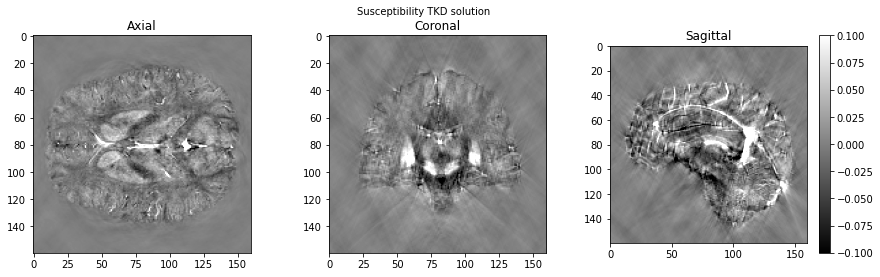

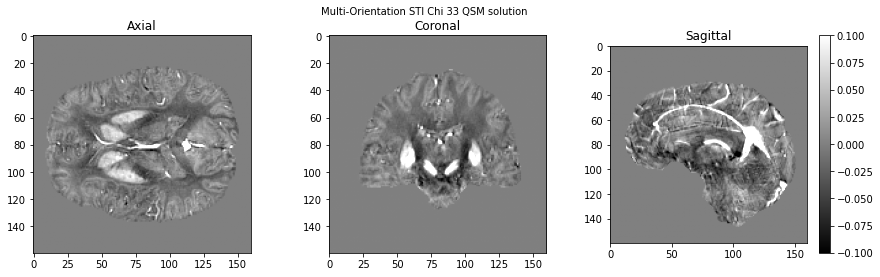

In [ ]:
chi_tgv_qsm = nib.load('20170327_qsm2016_recon_challenge/data/phs_wraptgv_qsm_recon__000.nii.gz').get_fdata()
view_slices_3d(chi_tgv_qsm, slice_nbr=80, vmin=-0.1, vmax=0.1, title='Susceptibility TGV solution')
view_slices_3d(chi_tkd, slice_nbr=80, vmin=-0.1, vmax=0.1, title='Susceptibility TKD solution')
view_slices_3d(chi, slice_nbr=80, vmin=-0.1, vmax=0.1, title='Multi-Orientation STI Chi 33 QSM solution')

# Running a complete QSM pipeline starting from DICOM data using QSMxT and NeuroDesk

# What is QSMxT (https://github.com/QSMxT/QSMxT)?
QSMxT is a complete and end-to-end QSM processing and analysis framework that excels at automatically reconstructing and processing QSM for large groups of participants.

QSMxT provides pipelines implemented in Python that:

1. Automatically convert DICOM data to the Brain Imaging Data Structure (BIDS)
2. Automatically reconstruct QSM, including steps for:
- Robust masking without anatomical priors
- Phase unwrapping (Laplacian based)
- Background field removal + dipole inversion (tgv_qsm)
- Multi-echo combination
3. Automatically generate a common group space for the whole study, as well as average magnitude and QSM images that facilitate group-level analyses.
4. Automatically segment T1w data and register them to the QSM space to extract quantitative values in anatomical regions of interest.
5. Export quantitative data to CSV for all subjects using the automated segmentations, or a custom segmentation in the group space.

QSMxT's containerised implementation makes all required external dependencies available in a reproducible and scalable way, supporting MacOS, Windows and Linux, and with options for parallel processing via PBS systems.

If you use QSMxT for a study, please cite https://doi.org/10.1101/2021.05.05.442850.

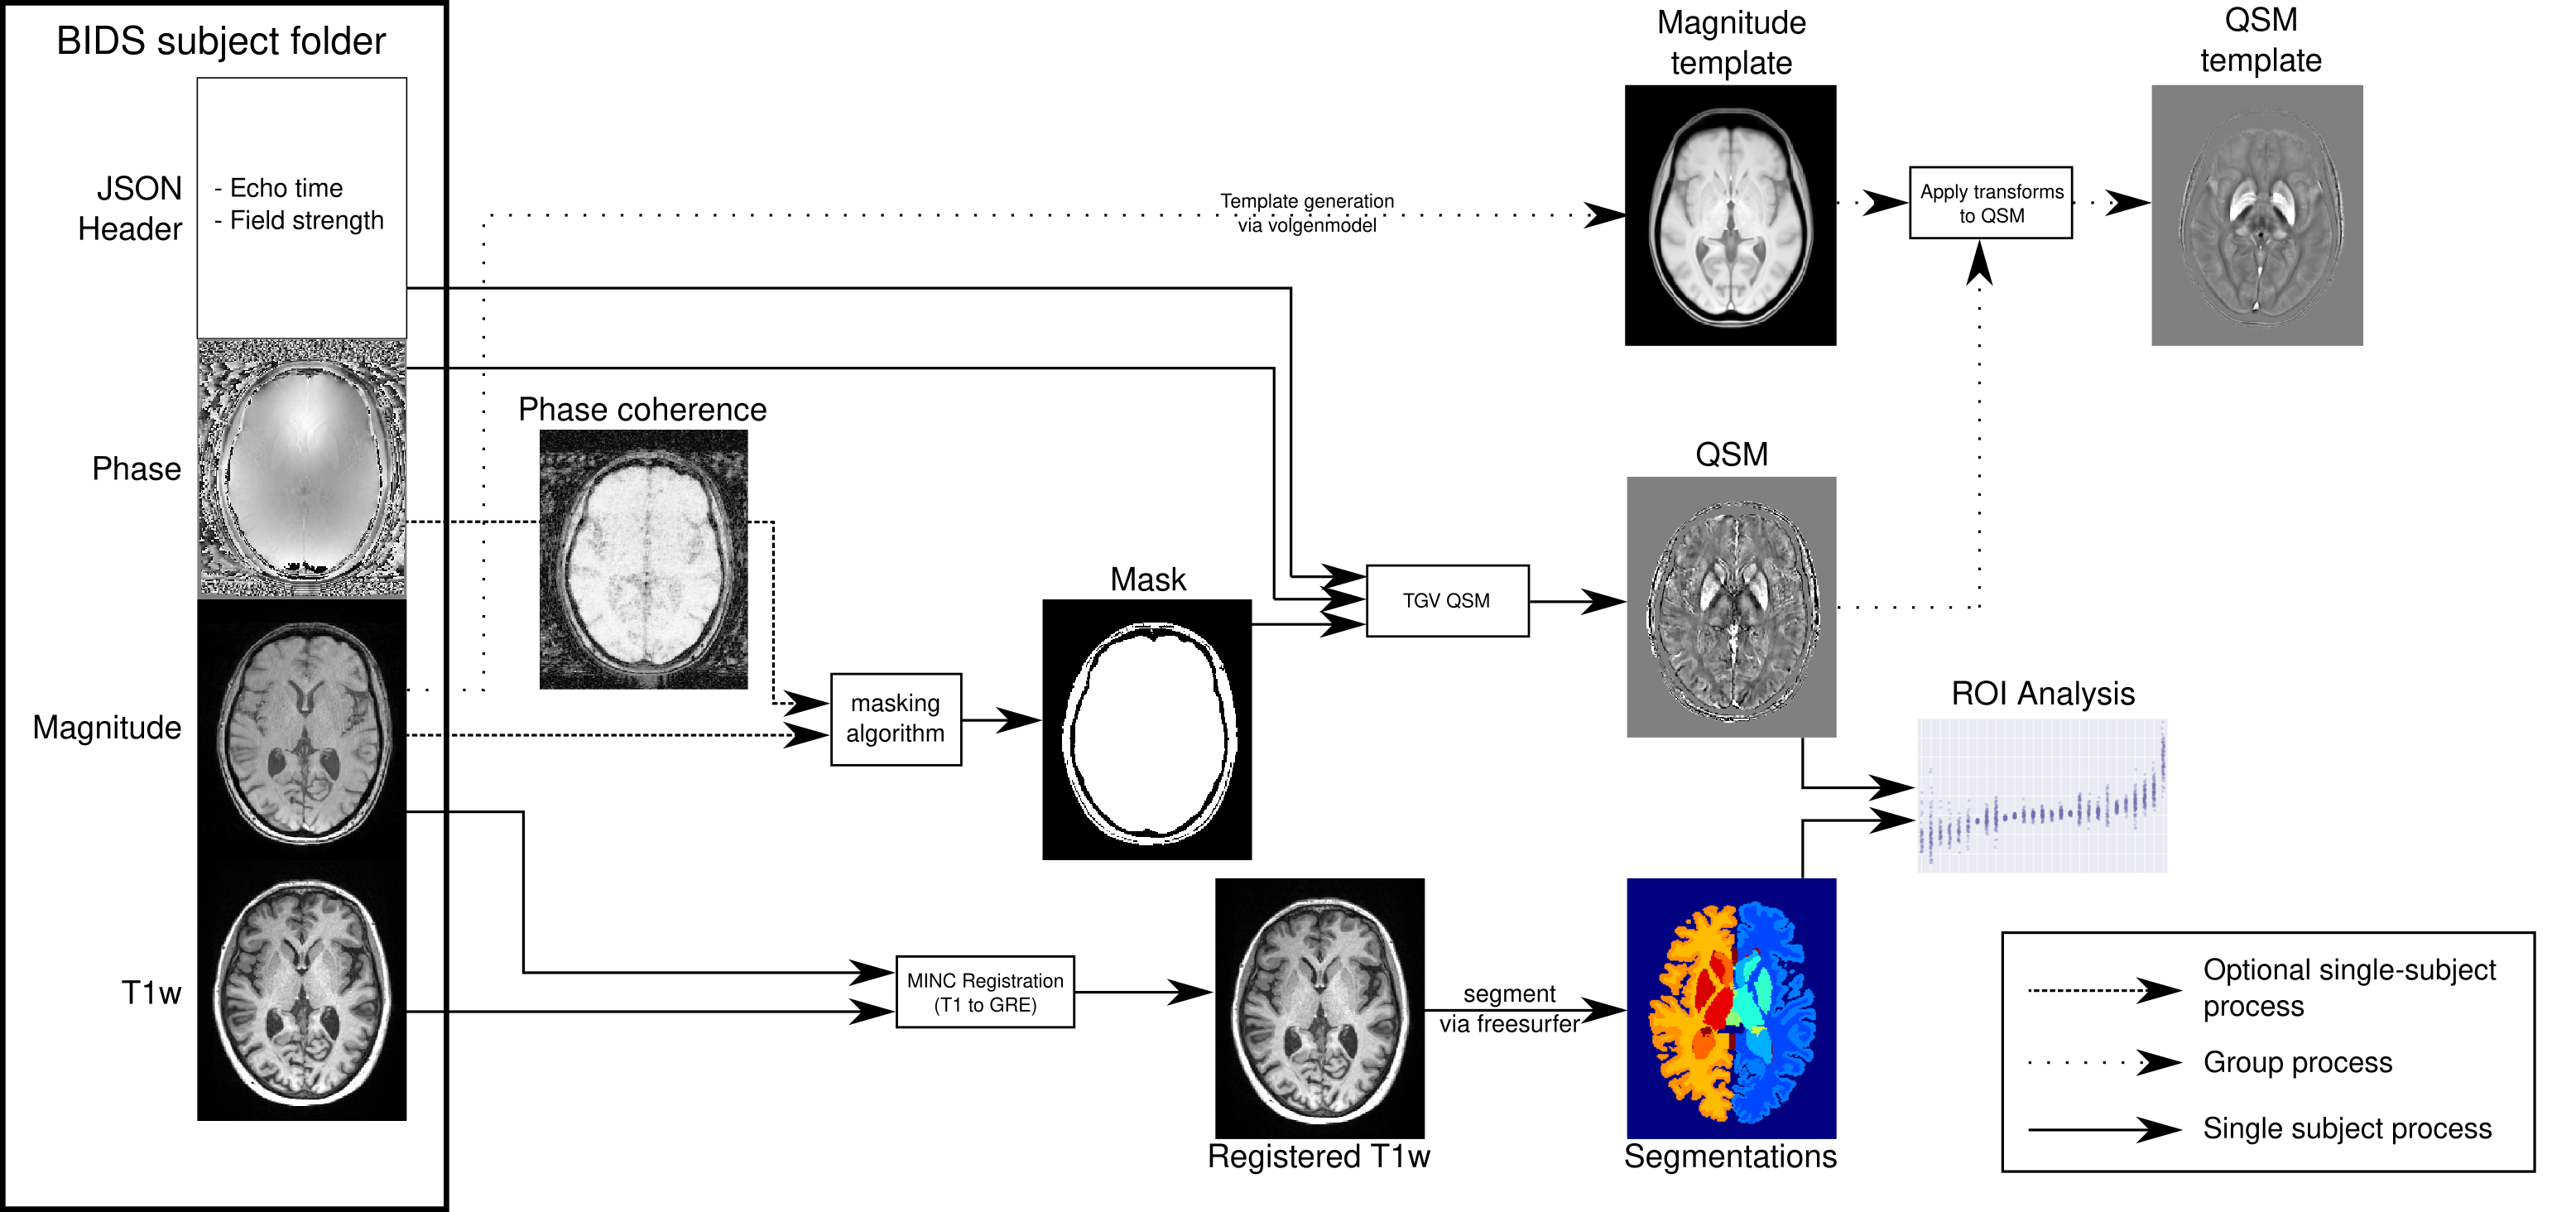

## Setup
In order to run this pipeline in Google Colab we have to do some tricks. We will use CVMFS (https://cvmfs.readthedocs.io/en/stable/), a software distribution service, to avoid downloading the full container. On your own Linux machine you can directly download the QSMxT container. Follow the instructions here: https://github.com/QSMxT/QSMxT

In [ ]:
# install CVMFS packages for ubuntu/debian:
!apt-get update >> /dev/null
!apt-get install lsb-release >> /dev/null
!wget https://ecsft.cern.ch/dist/cvmfs/cvmfs-release/cvmfs-release-latest_all.deb >> /dev/null
!dpkg -i cvmfs-release-latest_all.deb >> /dev/null
!rm -f cvmfs-release-latest_all.deb
!apt-get update >> /dev/null
!apt-get install cvmfs singularity-container tree >> /dev/null

# this is just a hack to avoid errors in colab - ignore when running on your system :)
import os
LD_PRELOAD = os.getenv('LD_PRELOAD')
print(LD_PRELOAD)
os.environ['LD_PRELOAD'] = ''

--2022-03-03 23:55:01--  https://ecsft.cern.ch/dist/cvmfs/cvmfs-release/cvmfs-release-latest_all.deb
Resolving ecsft.cern.ch (ecsft.cern.ch)... 188.184.97.7
Connecting to ecsft.cern.ch (ecsft.cern.ch)|188.184.97.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4986 (4.9K)
Saving to: ‘cvmfs-release-latest_all.deb’

cvmfs-release-lates 100%[===================>]   4.87K  --.-KB/s    in 0s      

2022-03-03 23:55:03 (152 MB/s) - ‘cvmfs-release-latest_all.deb’ saved [4986/4986]

/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4


In [ ]:
#setup cvmfs
!mkdir -p /etc/cvmfs/keys/ardc.edu.au/
!echo "-----BEGIN PUBLIC KEY-----" | sudo tee /etc/cvmfs/keys/ardc.edu.au/neurodesk.ardc.edu.au.pub
!echo "MIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAwUPEmxDp217SAtZxaBep" | sudo tee -a /etc/cvmfs/keys/ardc.edu.au/neurodesk.ardc.edu.au.pub
!echo "Bi2TQcLoh5AJ//HSIz68ypjOGFjwExGlHb95Frhu1SpcH5OASbV+jJ60oEBLi3sD" | sudo tee -a /etc/cvmfs/keys/ardc.edu.au/neurodesk.ardc.edu.au.pub
!echo "qA6rGYt9kVi90lWvEjQnhBkPb0uWcp1gNqQAUocybCzHvoiG3fUzAe259CrK09qR" | sudo tee -a /etc/cvmfs/keys/ardc.edu.au/neurodesk.ardc.edu.au.pub
!echo "pX8sZhgK3eHlfx4ycyMiIQeg66AHlgVCJ2fKa6fl1vnh6adJEPULmn6vZnevvUke" | sudo tee -a /etc/cvmfs/keys/ardc.edu.au/neurodesk.ardc.edu.au.pub
!echo "I6U1VcYTKm5dPMrOlY/fGimKlyWvivzVv1laa5TAR2Dt4CfdQncOz+rkXmWjLjkD" | sudo tee -a /etc/cvmfs/keys/ardc.edu.au/neurodesk.ardc.edu.au.pub
!echo "87WMiTgtKybsmMLb2yCGSgLSArlSWhbMA0MaZSzAwE9PJKCCMvTANo5644zc8jBe" | sudo tee -a /etc/cvmfs/keys/ardc.edu.au/neurodesk.ardc.edu.au.pub
!echo "NQIDAQAB" | sudo tee -a /etc/cvmfs/keys/ardc.edu.au/neurodesk.ardc.edu.au.pub
!echo "-----END PUBLIC KEY-----" | sudo tee -a /etc/cvmfs/keys/ardc.edu.au/neurodesk.ardc.edu.au.pub

!echo "CVMFS_USE_GEOAPI=yes" | sudo tee /etc/cvmfs/config.d/neurodesk.ardc.edu.au.conf
!echo 'CVMFS_SERVER_URL="http://cvmfs.neurodesk.org/cvmfs/@fqrn@"' | sudo tee -a /etc/cvmfs/config.d/neurodesk.ardc.edu.au.conf
!echo 'CVMFS_KEYS_DIR="/etc/cvmfs/keys/ardc.edu.au/"' | sudo tee -a /etc/cvmfs/config.d/neurodesk.ardc.edu.au.conf

!echo "CVMFS_HTTP_PROXY=DIRECT" | sudo tee  /etc/cvmfs/default.local
!echo "CVMFS_QUOTA_LIMIT=5000" | sudo tee -a  /etc/cvmfs/default.local

!cvmfs_config setup
!cvmfs_config chksetup
!cvmfs_config probe neurodesk.ardc.edu.au
!ls /cvmfs/neurodesk.ardc.edu.au/
# !cvmfs_config stat -v neurodesk.ardc.edu.au

-----BEGIN PUBLIC KEY-----
MIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAwUPEmxDp217SAtZxaBep
Bi2TQcLoh5AJ//HSIz68ypjOGFjwExGlHb95Frhu1SpcH5OASbV+jJ60oEBLi3sD
qA6rGYt9kVi90lWvEjQnhBkPb0uWcp1gNqQAUocybCzHvoiG3fUzAe259CrK09qR
pX8sZhgK3eHlfx4ycyMiIQeg66AHlgVCJ2fKa6fl1vnh6adJEPULmn6vZnevvUke
I6U1VcYTKm5dPMrOlY/fGimKlyWvivzVv1laa5TAR2Dt4CfdQncOz+rkXmWjLjkD
87WMiTgtKybsmMLb2yCGSgLSArlSWhbMA0MaZSzAwE9PJKCCMvTANo5644zc8jBe
NQIDAQAB
-----END PUBLIC KEY-----
CVMFS_USE_GEOAPI=yes
CVMFS_SERVER_URL="http://cvmfs.neurodesk.org/cvmfs/@fqrn@"
CVMFS_KEYS_DIR="/etc/cvmfs/keys/ardc.edu.au/"
CVMFS_HTTP_PROXY=DIRECT
CVMFS_QUOTA_LIMIT=5000
OK
Probing /cvmfs/neurodesk.ardc.edu.au... OK
containers  neurodesk-modules


Now we can access all our container images in the neurodesk project (https://github.com/NeuroDesk/neurodesk/):

In [ ]:
!ls /cvmfs/neurodesk.ardc.edu.au/containers

afni_21.2.00_20210714		    lcmodel_6.3_20210302
aidamri_1.1_20210708		    lcmodel_6.3_20220222
aidmri_1.1_20210330		    minc_1.9.17_20210105
ants_2.3.1_20211204		    mne_0.23.4_20220117
ants_2.3.4_20210104		    mne_0.23.4_20220121
ants_2.3.4_20211212		    modules
ants_2.3.5_20211212		    mricrogl_1.2.20211006_20211218
ashs_2.0.0_20210105		    mricrogl_1.2.20211006_20220111
aslprep_0.2.7_20210323		    mriqc_0.15.2_20201104
bart_0.7.00_20210302		    mriqc_0.16.1_20210917
bidscoin_3.7.0_20220302		    mritools_3.3.0_20220224
bidstools_1.0.0_20201208	    mrtrix3_3.0.1_20200908
brainstorm_3.211130_20211202	    mrtrix3_3.0.2_20201125
brainstorm_3.211130_20211207	    mrtrix3_3.0.3_20210917
cat12_r1904_20220121		    mrtrix3tissue_5.2.8_20201111
cat12_r1933_20220128		    niistat_1.0.20191216_20220111
clearswi_1.0.0_20211018		    oshyx_0.2_20211201
code_220114_20220117		    oshyx_0.3_20220110
code_220114_20220121		    palm_alpha119_20211220
condaenvs_1.0.0_20211011	    physio_r2021a_20220220
conn

and we can execute any tool we need:

In [ ]:
!singularity exec /cvmfs/neurodesk.ardc.edu.au/containers/qsmxt_1.1.10_20220302/qsmxt_1.1.10_20220302.simg dcm2niix

Chris Rorden's dcm2niiX version v1.0.20211215  GCC7.5.0 x86-64 (64-bit Linux)
usage: dcm2niix [options] <in_folder>
 Options :
  -1..-9 : gz compression level (1=fastest..9=smallest, default 6)
  -a : adjacent DICOMs (images from same series always in same folder) for faster conversion (n/y, default n)
  -b : BIDS sidecar (y/n/o [o=only: no NIfTI], default y)
   -ba : anonymize BIDS (y/n, default y)
  -c : comment stored in NIfTI aux_file (provide up to 24 characters e.g. '-c first_visit')
  -d : directory search depth. Convert DICOMs in sub-folders of in_folder? (0..9, default 5)
  -e : export as NRRD (y) or MGH (o) instead of NIfTI (y/n/o, default n)
  -f : filename (%a=antenna (coil) name, %b=basename, %c=comments, %d=description, %e=echo number, %f=folder name, %g=accession number, %i=ID of patient, %j=seriesInstanceUID, %k=studyInstanceUID, %m=manufacturer, %n=name of patient, %o=mediaObjectInstanceUID, %p=protocol, %r=instance number, %s=series number, %t=time, %u=acquisition num

## Download data
We prepared a small example dataset. It was acquired on a 3T Siemens PrismaFit with a GRE sequence, 20ms echotime and 1mm resolution.

Let's download the data from the open science foundation: https://osf.io/ru43c/

In [ ]:
!pip install osfclient
!osf -p ru43c clone .

0files [00:00, ?files/s]
  0% 0.00/39.1M [00:00<?, ?bytes/s]
 11% 4.21M/39.1M [00:00<00:05, 6.28Mbytes/s]
 49% 19.1M/39.1M [00:00<00:00, 31.4Mbytes/s]
100% 39.1M/39.1M [00:02<00:00, 19.0Mbytes/s]
1files [00:07,  7.58s/files]
  0% 0.00/64.7M [00:00<?, ?bytes/s]
  7% 4.21M/64.7M [00:00<00:04, 12.6Mbytes/s]
 13% 8.40M/64.7M [00:00<00:03, 18.7Mbytes/s]
 32% 20.8M/64.7M [00:00<00:00, 47.4Mbytes/s]
 52% 33.6M/64.7M [00:01<00:01, 20.8Mbytes/s]
100% 64.7M/64.7M [00:01<00:00, 38.1Mbytes/s]
2files [00:10,  4.85s/files]
  0% 0.00/16.0M [00:00<?, ?bytes/s]
100% 16.0M/16.0M [00:00<00:00, 37.1Mbytes/s]
3files [00:12,  3.46s/files]
  0% 0.00/29.2M [00:00<?, ?bytes/s]
 14% 4.21M/29.2M [00:00<00:01, 18.5Mbytes/s]
100% 29.2M/29.2M [00:01<00:00, 26.8Mbytes/s]
4files [00:15,  3.39s/files]
  0% 0.00/32.1M [00:00<?, ?bytes/s]
 13% 4.21M/32.1M [00:00<00:01, 17.6Mbytes/s]
 26% 8.40M/32.1M [00:00<00:01, 14.7Mbytes/s]
100% 32.1M/32.1M [00:00<00:00, 45.8Mbytes/s]
5files [00:17,  2.82s/files]
  0% 0.00/16.6M [00:

There are two participants in this dataset:

In [ ]:
!tree osfstorage/GRE_2subj_1mm_TE20ms

osfstorage/GRE_2subj_1mm_TE20ms
├── sub1
│   ├── GR_M_5_QSM_p2_1mmIso_TE20.zip
│   └── GR_P_6_QSM_p2_1mmIso_TE20.zip
└── sub2
    ├── GR_M_5_QSM_p2_1mmIso_TE20.zip
    └── GR_P_6_QSM_p2_1mmIso_TE20.zip

2 directories, 4 files


We can now unzip this data:

In [ ]:
!unzip osfstorage/GRE_2subj_1mm_TE20ms/sub1/GR_M_5_QSM_p2_1mmIso_TE20.zip -d dicoms >> /dev/null
!unzip osfstorage/GRE_2subj_1mm_TE20ms/sub1/GR_P_6_QSM_p2_1mmIso_TE20.zip -d dicoms >> /dev/null
!unzip osfstorage/GRE_2subj_1mm_TE20ms/sub2/GR_M_5_QSM_p2_1mmIso_TE20.zip -d dicoms >> /dev/null
!unzip osfstorage/GRE_2subj_1mm_TE20ms/sub2/GR_P_6_QSM_p2_1mmIso_TE20.zip -d dicoms >> /dev/null

## run QSMxT via neurodesk
First step is to sort the DICOM data and then convert the data to BIDS:


```
python3 /opt/QSMxT/run_0_dicomSort.py REPLACE_WITH_YOUR_DICOM_INPUT_DATA_DIRECTORY 00_dicom
```




In [ ]:
!singularity exec --bind /content:/data /cvmfs/neurodesk.ardc.edu.au/containers/qsmxt_1.1.10_20220302/qsmxt_1.1.10_20220302.simg python3 /opt/QSMxT/run_0_dicomSort.py /data/dicoms /data/00_dicom

reading file list...
640 dicom files found.
sorting dicoms in /data/00_dicom...
Identified subject: 17_07_05-13_44_31-std-1_3_12_2_1107_5_2_43_167001
Identified session: 17_07_05-13_44_31-std-1_3_12_2_1107_5_2_43_167001 #1 20170705
Identified series: sub-17_07_05-13_44_31-std-1_3_12_2_1107_5_2_43_167001/ses-1/5_qsm_p2_1mmiso_te20
Identified subject: 17_07_06-16_05_06-std-1_3_12_2_1107_5_2_43_167001
Identified session: 17_07_06-16_05_06-std-1_3_12_2_1107_5_2_43_167001 #1 20170706
Identified series: sub-17_07_06-16_05_06-std-1_3_12_2_1107_5_2_43_167001/ses-1/5_qsm_p2_1mmiso_te20
Identified series: sub-17_07_05-13_44_31-std-1_3_12_2_1107_5_2_43_167001/ses-1/6_qsm_p2_1mmiso_te20
Identified series: sub-17_07_06-16_05_06-std-1_3_12_2_1107_5_2_43_167001/ses-1/6_qsm_p2_1mmiso_te20
done sorting dicoms.


this step sorted the dicoms in subjects/sessions/scans:

In [ ]:
!tree 00_dicom -L 3

00_dicom
├── sub-17_07_05-13_44_31-std-1_3_12_2_1107_5_2_43_167001
│   └── ses-1
│       ├── 5_qsm_p2_1mmiso_te20
│       └── 6_qsm_p2_1mmiso_te20
└── sub-17_07_06-16_05_06-std-1_3_12_2_1107_5_2_43_167001
    └── ses-1
        ├── 5_qsm_p2_1mmiso_te20
        └── 6_qsm_p2_1mmiso_te20

8 directories, 0 files


now we can convert the sorted DICOMs to BIDS.

```
python3 /opt/QSMxT/run_1_dicomConvert.py 00_dicom 01_bids
```



In [ ]:
!singularity exec --bind /content:/data /cvmfs/neurodesk.ardc.edu.au/containers/qsmxt_1.1.10_20220302/qsmxt_1.1.10_20220302.simg python3 /opt/QSMxT/run_1_dicomConvert.py /data/00_dicom /data/01_bids --t2starw_series_patterns *qsm* --t1w_series_patterns *mprage* --auto_yes

Converting all DICOMs to nifti...
Enumerating series names from JSON headers in '/data/01_bids/.../extra_data' folders...
All series names identified: ['qsm_p2_1mmiso_te20']
Chosen t2starw patterns ['*qsm*'] matched with the following series: ['qsm_p2_1mmiso_te20']
Parsing JSON headers...
Renaming files...
Renaming /data/01_bids/sub-170706-160506-std-1312211075243167001/ses-1/extra_data/5_qsm_p2_1mmiso_te20_QSM_p2_1mmIso_TE20_20170706160553_5.json -> /data/01_bids/sub-170706-160506-std-1312211075243167001/ses-1/anat/sub-170706-160506-std-1312211075243167001_ses-1_run-1_part-magnitude_T2starw.json
Renaming /data/01_bids/sub-170706-160506-std-1312211075243167001/ses-1/extra_data/5_qsm_p2_1mmiso_te20_QSM_p2_1mmIso_TE20_20170706160553_5.nii -> /data/01_bids/sub-170706-160506-std-1312211075243167001/ses-1/anat/sub-170706-160506-std-1312211075243167001_ses-1_run-1_part-magnitude_T2starw.nii
Renaming /data/01_bids/sub-170706-160506-std-1312211075243167001/ses-1/extra_data/6_qsm_p2_1mmiso_te20

This dataset has only one echo-time, but QSMxT will work for multi-echo data as well. This is the resulting BIDS structure:


In [ ]:
!tree 01_bids

01_bids
├── sub-170705-134431-std-1312211075243167001
│   └── ses-1
│       ├── anat
│       │   ├── sub-170705-134431-std-1312211075243167001_ses-1_run-1_part-magnitude_T2starw.json
│       │   ├── sub-170705-134431-std-1312211075243167001_ses-1_run-1_part-magnitude_T2starw.nii
│       │   ├── sub-170705-134431-std-1312211075243167001_ses-1_run-1_part-phase_T2starw.json
│       │   └── sub-170705-134431-std-1312211075243167001_ses-1_run-1_part-phase_T2starw.nii
│       └── extra_data
│           └── dcm2niix_output.txt
└── sub-170706-160506-std-1312211075243167001
    └── ses-1
        ├── anat
        │   ├── sub-170706-160506-std-1312211075243167001_ses-1_run-1_part-magnitude_T2starw.json
        │   ├── sub-170706-160506-std-1312211075243167001_ses-1_run-1_part-magnitude_T2starw.nii
        │   ├── sub-170706-160506-std-1312211075243167001_ses-1_run-1_part-phase_T2starw.json
        │   └── sub-170706-160506-std-1312211075243167001_ses-1_run-1_part-phase_T2starw.nii
        └── ext

Let's have a quick look at the phase and magnitude data of one particiapnt:


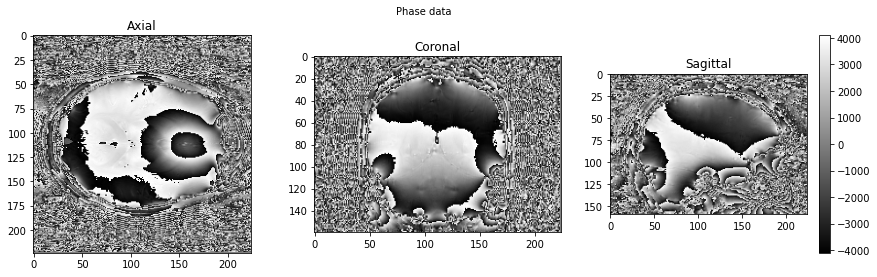

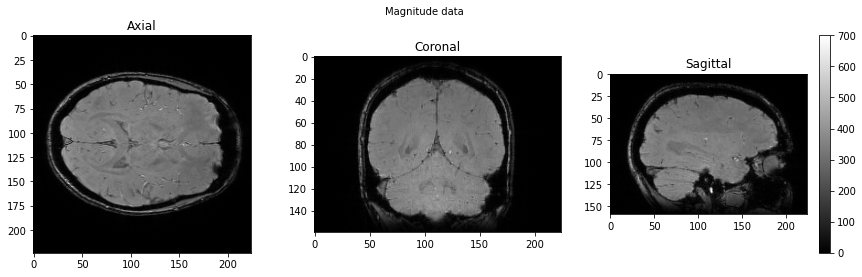

In [ ]:
import nibabel as nib
import numpy as np
from matplotlib import transforms
from scipy import ndimage
import pickle

phase = nib.load('01_bids/sub-170705-134431-std-1312211075243167001/ses-1/anat/sub-170705-134431-std-1312211075243167001_ses-1_run-1_part-phase_T2starw.nii').get_fdata()
mag = nib.load('01_bids/sub-170705-134431-std-1312211075243167001/ses-1/anat/sub-170705-134431-std-1312211075243167001_ses-1_run-1_part-magnitude_T2starw.nii').get_fdata()

view_slices_3d(phase, slice_nbr=80, vmin=-4096, vmax=4096, title='Phase data')
view_slices_3d(mag, slice_nbr=80, vmin=0, vmax=700, title='Magnitude data')

now we can run the pipeline generating quantiative suscepitiblity maps (this will take 32 minutes to process, so uncomment the line below if you like to run this):

```
python3 /opt/QSMxT/run_2_qsm.py 01_bids 02_qsm_output
```



In [ ]:
os.environ['PYTHONPATH'] = '/opt/QSMxT:/TGVQSM-master-011045626121baa8bfdd6633929974c732ae35e3/TGV_QSM'

#uncomment the next line if you want to run the pipeline (takes 60 minutes)
# !singularity exec --bind /content:/data /cvmfs/neurodesk.ardc.edu.au/containers/qsmxt_1.1.10_20220302/qsmxt_1.1.10_20220302.simg python3 /opt/QSMxT/run_2_qsm.py /data/01_bids /data/02_qsm_output 

Running with 2 procesors
220304-00:10:36,255 nipype.utils WARNING:
	 A newer version (1.7.0) of nipy/nipype is available. You are using 1.6.0
220304-00:10:42,500 nipype.workflow INFO:
	 Workflow workflow_qsm settings: ['check', 'execution', 'logging', 'monitoring']
220304-00:10:42,817 nipype.workflow INFO:
	 Running in parallel.
220304-00:10:47,205 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 11.42/11.42, Free processors: 2/2.
220304-00:10:47,266 nipype.workflow INFO:
	 [Node] Setting-up "workflow_qsm.sub-170705-134431-std-1312211075243167001.ses-1.select_files" in "/data/02_qsm_output/workflow_qsm/sub-170705-134431-std-1312211075243167001/ses-1/_run_run-1/select_files".
220304-00:10:47,267 nipype.workflow INFO:
	 [Node] Setting-up "workflow_qsm.sub-170706-160506-std-1312211075243167001.ses-1.select_files" in "/data/02_qsm_output/workflow_qsm/sub-170706-160506-std-1312211075243167001/ses-1/_run_run-1/select_files".
220304-00:10:47,273 nipype.

This is the QSM output structure:

In [ ]:
#copy precomputed results:
!mkdir -p 02_qsm_output/qsm_final/_run_run-1 && cp osfstorage/results/* 02_qsm_output/qsm_final/_run_run-1

!tree 02_qsm_output/qsm_final

02_qsm_output/qsm_final
└── _run_run-1
    ├── sub-170705134431std1312211075243167001_ses-1_acq-qsmPH00_run-1_phase_scaled_qsm-filled_000_average.nii
    ├── sub-170705-134431-std-1312211075243167001_ses-1_run-1_part-phase_T2starw_scaled_qsm_000_composite_average.nii
    ├── sub-170706160506std1312211075243167001_ses-1_acq-qsmPH00_run-1_phase_scaled_qsm-filled_000_average.nii
    └── sub-170706-160506-std-1312211075243167001_ses-1_run-1_part-phase_T2starw_scaled_qsm_000_composite_average.nii

1 directory, 4 files


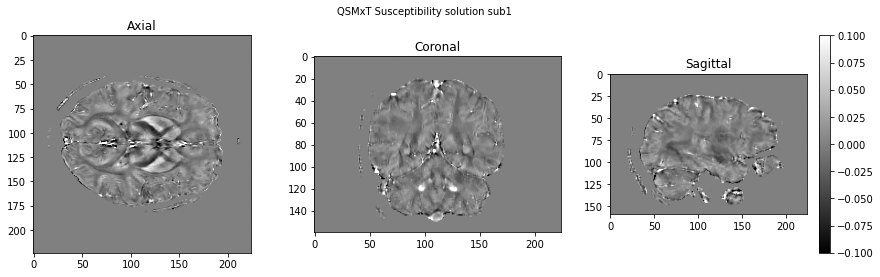

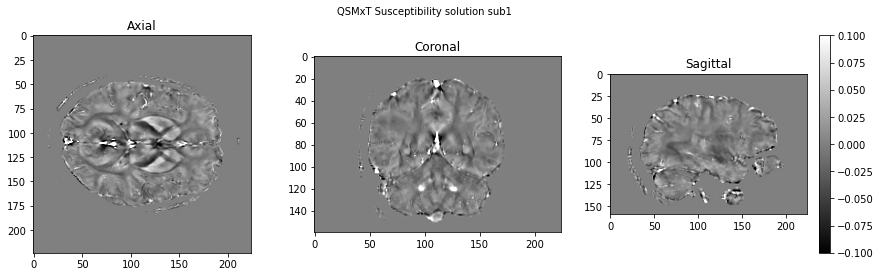

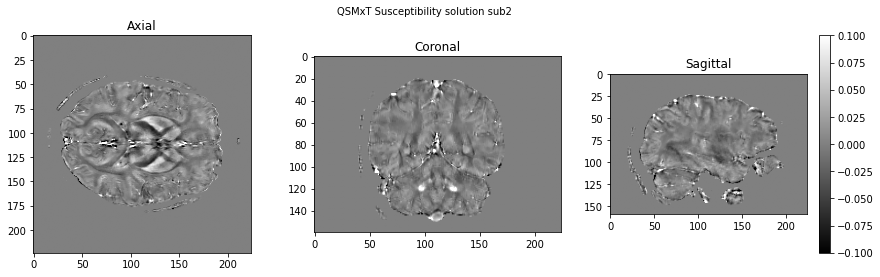

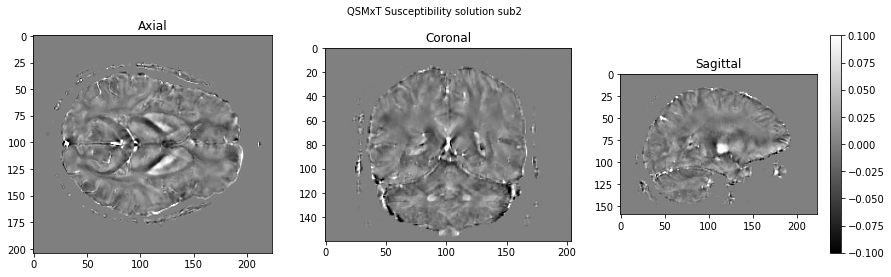

In [ ]:

chi_qsmxt_1_precomputed = nib.load('02_qsm_output/qsm_final/_run_run-1/sub-170705134431std1312211075243167001_ses-1_acq-qsmPH00_run-1_phase_scaled_qsm-filled_000_average.nii').get_fdata()
chi_qsmxt_2_precomputed = nib.load('02_qsm_output/qsm_final/_run_run-1/sub-170706160506std1312211075243167001_ses-1_acq-qsmPH00_run-1_phase_scaled_qsm-filled_000_average.nii').get_fdata()

# chi_qsmxt_1 = nib.load('02_qsm_output/qsm_final/_run_run-1/sub-170705-134431-std-1312211075243167001_ses-1_run-1_part-phase_T2starw_scaled_qsm_000_composite_average.nii').get_fdata()
# chi_qsmxt_2 = nib.load('02_qsm_output/qsm_final/_run_run-1/sub-170705-134431-std-1312211075243167001_ses-1_run-1_part-phase_T2starw_scaled_qsm_000_composite_average.nii').get_fdata()

# view_slices_3d(chi_qsmxt_1, slice_nbr=80, vmin=-0.1, vmax=0.1, title='QSMxT Susceptibility solution sub1')
view_slices_3d(chi_qsmxt_1_precomputed, slice_nbr=80, vmin=-0.1, vmax=0.1, title='QSMxT Susceptibility solution sub1')
# view_slices_3d(chi_qsmxt_2, slice_nbr=80, vmin=-0.1, vmax=0.1, title='QSMxT Susceptibility solution sub2')
view_slices_3d(chi_qsmxt_2_precomputed, slice_nbr=80, vmin=-0.1, vmax=0.1, title='QSMxT Susceptibility solution sub2')

If an MPRAGE/MP2RAGE/T1 weighted image suitable for FreeSurfer was also collected, the QSMxT pipeline can segment this data and extract information from multiple regions of interest. In this example we do not have an anatomical scan, but these would be the steps to run: 

```
python3 /opt/QSMxT/run_3_segment.py 01_bids 03_segmentation
```



QSMxT can also register all data of the participants into a common group space, which could make a group analysis easier:

```
python3 /opt/QSMxT/run_4_template.py 01_bids 02_qsm_output 04_template
```



And this is how you can export the ROI information into CSV files for further processing:

```
python3 /opt/QSMxT/run_5_analysis.py --labels_file /opt/QSMxT/aseg_labels.csv --segmentations 03_segmentation/qsm_segmentations/*.nii --qsm_files 02_qsm_output/qsm_final/*/*.nii --out_dir 06_analysis
```




or export quantitative data to CSV using a custom segmentation

```
python3 /opt/QSMxT/run_5_analysis.py --segmentations my_segmentation.nii --qsm_files 04_qsm_template/qsm_transformed/*/*.nii --out_dir 07_analysis
```


